# Risk Management and Volatility Threshold Strategies in Pairs Trading
This notebook implements risk management and volatility-based strategies for pairs trading using Python. The key concepts demonstrated include:
- Stop-Loss Orders
- Position Sizing
- Volatility Threshold Strategy

Lets start by importing the libraries first

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Next, we will make functions for each of our utilities. For understanding what all of these functions are, refer to the supporting document and feel free to search the internet for the same.

In [2]:
# Fetch Historical Stock Prices
def fetch_stock_data(tickers, start_date="2015-01-01", end_date="2024-01-01"):
    data = yf.download(tickers, start=start_date, end=end_date)["Close"]
    return data

In [3]:
# Stop Loss Function: Stop trading if the spread exceeds a threshold
def stop_loss(spread, threshold=2):
    return spread > threshold  # Exiting position if spread exceeds threshold

In [4]:
# Position Sizing Based on Volatility: Larger position sizes for lower volatility
def position_sizing(spread, risk_factor=0.10):  # Increased risk factor to 0.10
    # Convert spread to pandas Series if it's numpy ndarray
    spread = pd.Series(spread)

    # Compute the volatility of the spread (Rolling Standard Deviation)
    spread_volatility = spread.rolling(window=30).std()

    # Calculate position size based on risk factor and volatility
    position_size = risk_factor / spread_volatility
    return position_size.fillna(0)  # Fill NaNs for the initial period

In [5]:
# Volatility Threshold: Enter trade only when volatility exceeds a threshold
def volatility_threshold(spread, threshold=0.02):  # Decreased volatility threshold to 0.02
    spread_volatility = pd.Series(spread).rolling(window=30).std()
    return spread_volatility > threshold

In [6]:
# Backtest with Risk Management: Combine all techniques into a backtest
def backtest_with_risk_management(data, stock1, stock2, stop_loss_threshold=2, risk_factor=0.10, volatility_threshold_value=0.02):
    # Calculate Spread between two stocks
    spread = data[stock2] - data[stock1]

    # Apply stop-loss rule
    stop_loss_flag = stop_loss(spread, stop_loss_threshold)

    # Apply volatility threshold rule
    volatility_flag = volatility_threshold(spread, volatility_threshold_value)

    # Calculate position sizes(manually multiplied by 10000 to scale everything up, and thus we have a higher capital to work with)
    position_size = position_sizing(spread, risk_factor)*10000

    # Compute daily returns and backtest logic
    daily_returns = spread.pct_change().shift(-1).fillna(0)

    # Initialize position (always buy or sell 10000, thus indicating a higher capital)
    position = np.zeros(len(spread))*10000

    # When volatility exceeds threshold, we enter the trade
    position[volatility_flag] = position_size[volatility_flag]

    # Stop loss condition: Exiting the position if stop-loss is triggered
    position[stop_loss_flag] = 0

    # Compute PnL
    pnl = position * daily_returns
    cumulative_pnl = pnl.cumsum()

    return cumulative_pnl, pnl

In [8]:
# Backtest without Risk Management (non-risk-managed strategy) (used for comparing)
def backtest_without_risk_management(data, stock1, stock2):
    # Calculate Spread between two stocks
    spread = data[stock2] - data[stock1]

    # Compute daily returns and backtest logic
    daily_returns = spread.pct_change().shift(-1).fillna(0)

    # Position size is always 10000
    position = np.ones(len(spread))*10000

    # Compute PnL for non-risk-managed strategy
    pnl = position * daily_returns
    cumulative_pnl = pnl.cumsum()

    return cumulative_pnl, pnl

In [15]:
# Run the simulation for a sample pair of stocks
tickers = ["MSFT", "AAPL"]
data = fetch_stock_data(tickers)

# Run backtest with risk management techniques (increase risk factor and volatility threshold)
cumulative_pnl_rm, pnl_rm = backtest_with_risk_management(data, 'MSFT', 'AAPL', stop_loss_threshold=2, risk_factor=0.2, volatility_threshold_value=0.02)

# Run backtest without risk management
cumulative_pnl_non_rm, pnl_non_rm = backtest_without_risk_management(data, 'MSFT', 'AAPL')

[*********************100%***********************]  2 of 2 completed


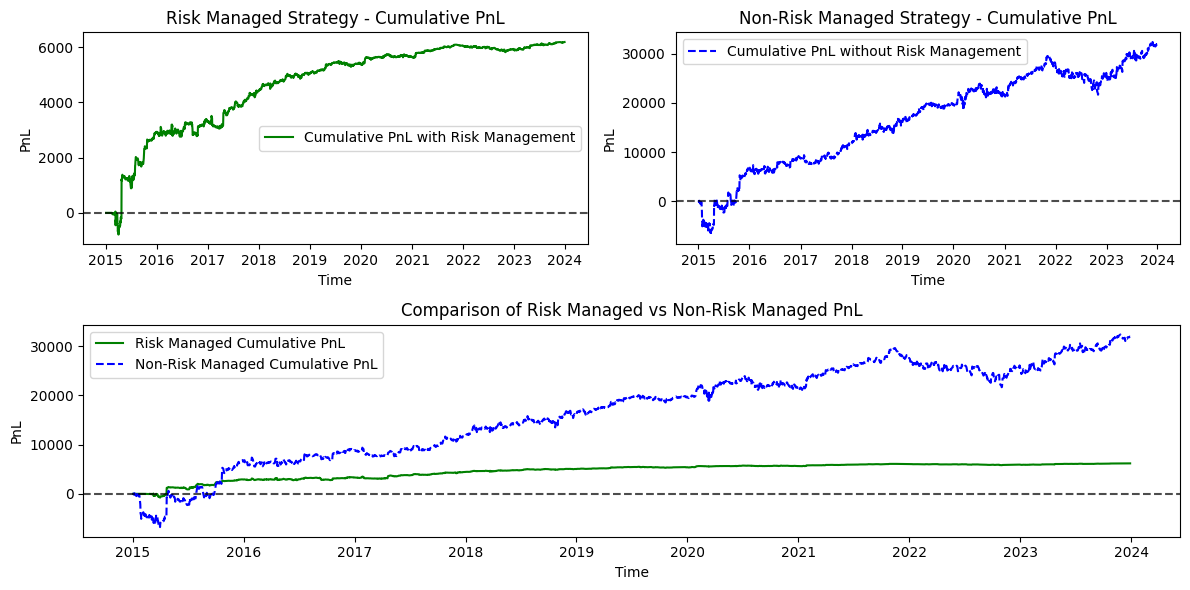

Final Cumulative PnL (Risk Managed): 6181.68
Final Cumulative PnL (Non-Risk Managed): 31949.59


In [16]:
# Plot the Results
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(cumulative_pnl_rm, label="Cumulative PnL with Risk Management", color="green")
plt.axhline(0, color="black", linestyle="--", alpha=0.7)
plt.title("Risk Managed Strategy - Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(cumulative_pnl_non_rm, label="Cumulative PnL without Risk Management", color="blue", linestyle="--")
plt.axhline(0, color="black", linestyle="--", alpha=0.7)
plt.title("Non-Risk Managed Strategy - Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.legend()

# Combined Plot
plt.subplot(2, 1, 2)
plt.plot(cumulative_pnl_rm, label="Risk Managed Cumulative PnL", color="green")
plt.plot(cumulative_pnl_non_rm, label="Non-Risk Managed Cumulative PnL", color="blue", linestyle="--")
plt.axhline(0, color="black", linestyle="--", alpha=0.7)
plt.title("Comparison of Risk Managed vs Non-Risk Managed PnL")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.legend()
plt.tight_layout()
plt.show()

# Print Final PnL for comparison
print(f"Final Cumulative PnL (Risk Managed): {cumulative_pnl_rm.iloc[-1]:.2f}")
print(f"Final Cumulative PnL (Non-Risk Managed): {cumulative_pnl_non_rm.iloc[-1]:.2f}")


Sometimes, more the risk more the reward :)